In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import  plotly
import datetime

In [2]:
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime.today()

In [4]:
data = yf.download(tickers='BTC-USD', start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
len(data)

2748

<center> <h1> Create useful technical indicators</h1> </center>                                         

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) is a versatile indicator that can be used to identify a new trend or warn of extreme conditions. It was originally developed  to identify cyclical turns in commodities, but the indicator can be successfully applied to indices, ETFs, stocks and other securities. In general, CCI measures the current price level relative to an average price level over a given period of time. CCI is relatively high when prices are far above their average, but is relatively low when prices are far below their average. In this manner, CCI can be used to identify overbought and oversold levels. 

$$CCI = (Typical Price - 20-period\:  SMA \: of \: TP) / (.015 \cdot Mean\, Deviation)$$

$$Typical Price (TP) = (High + Low + Close)/3$$

$$Constant = .015$$

In [7]:
def CCI(df, ndays): 
    df['TP'] = (data['High'] + data['Low'] + data['Close']) / 3 
    df['sma'] = df['TP'].rolling(ndays).mean()
    df['mad'] = df['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
    return df

In [8]:
data=CCI(data,20)

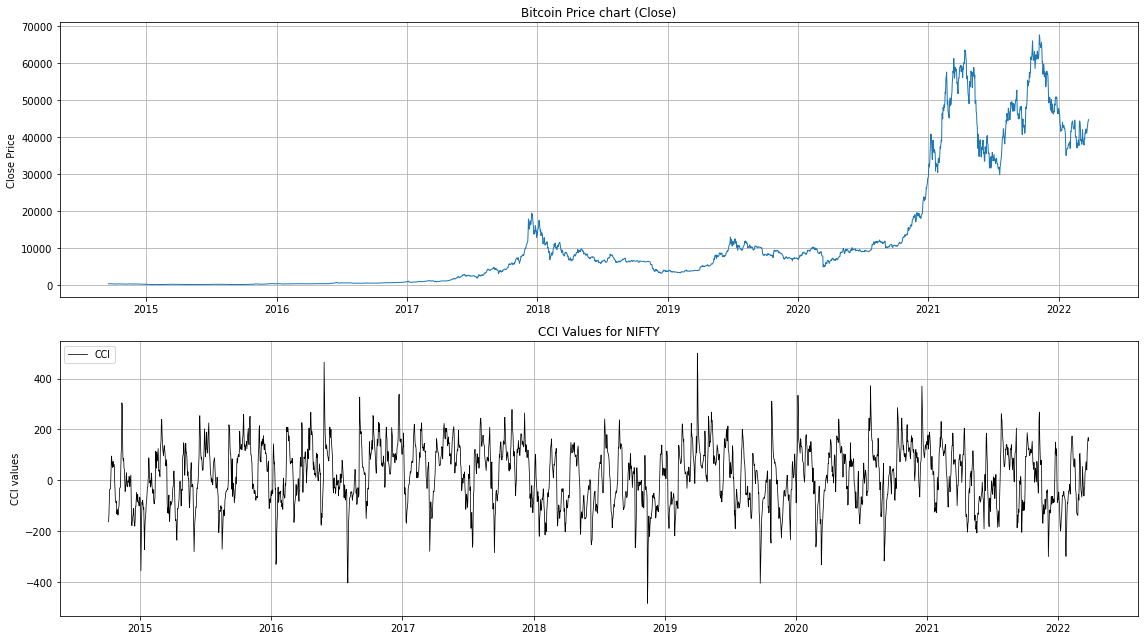

In [9]:
# Plot the price series chart and the Commodity Channel index
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(2, 1, 1)
plt.plot(data['Close'],lw=1)
plt.title('Bitcoin Price chart (Close)')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(data['CCI'],'k',lw=0.75,linestyle='-',label='CCI')
plt.title('CCI Values for NIFTY')
plt.legend(loc=2,prop={'size':9.5})
plt.ylabel('CCI values')
plt.grid(True)
#plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.tight_layout()
plt.show()

### Exponential moving average

An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period. 

$$EMA_{today}= ClosingPrice_{today}\cdot\frac{Smoothing}{1+Days}+EMA_{yesterday}\cdot ({1-\frac{Smoothing}{1+Days}}) $$

Where:
- Smoothing=2 

In [9]:
def EWMA(data, ndays): 
    EMA = pd.Series(data['Close'].ewm(span = ndays, min_periods = ndays).mean(), name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    
    return data

##### 10-period exponential moving average

In [10]:
data=EWMA(data,10)

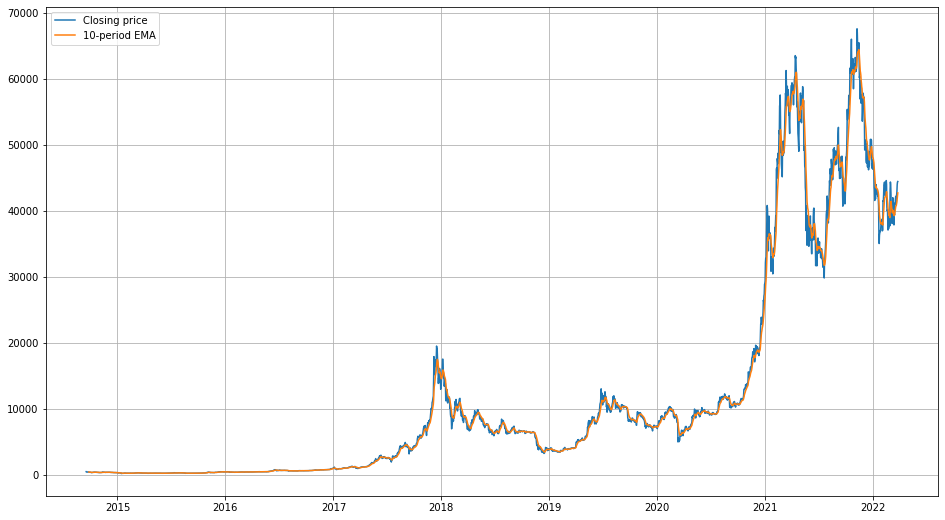

In [11]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['EWMA_10'],label="10-period EMA")
plt.legend()
plt.grid(True)

##### 20-period exponential moving average

In [12]:
data=EWMA(data,20)

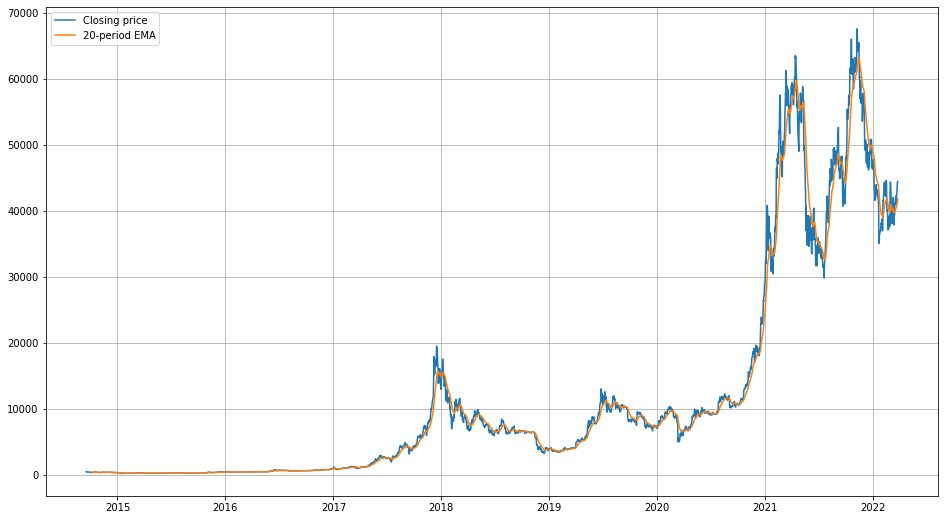

In [13]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['EWMA_20'],label="20-period EMA")
plt.legend()
plt.grid(True)

##### 50-period exponential moving average

In [14]:
data=EWMA(data,50)

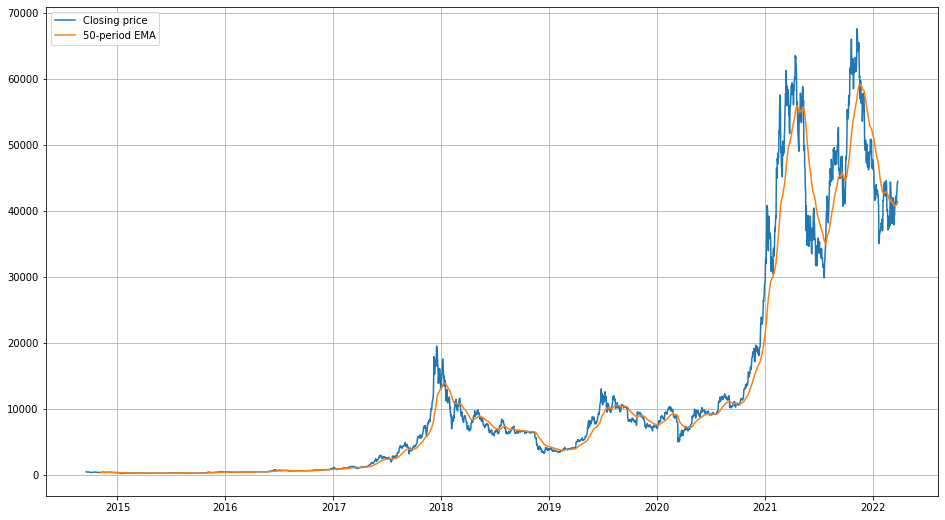

In [15]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['EWMA_50'],label="50-period EMA")
plt.legend()
plt.grid(True)

##### 100-period exponential moving average

In [16]:
data=EWMA(data,100)

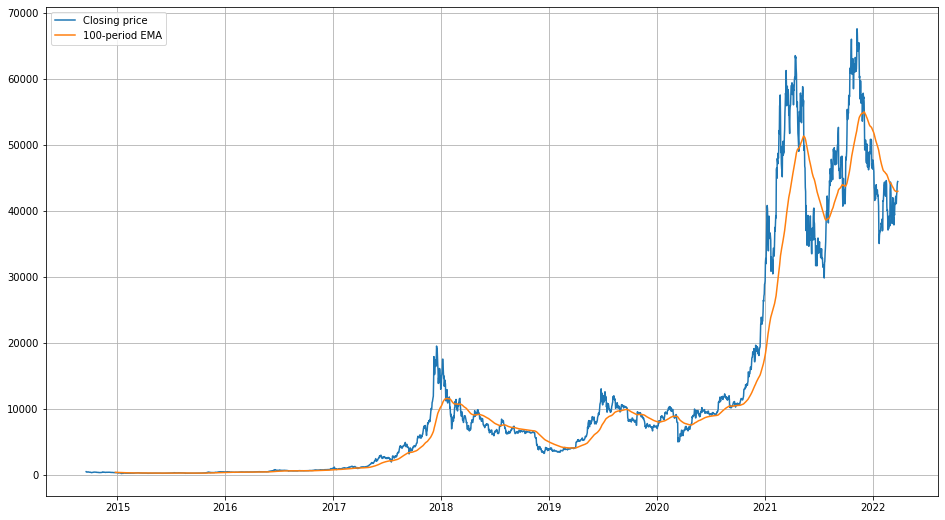

In [17]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['EWMA_100'],label="100-period EMA")
plt.legend()
plt.grid(True)

### RSI
The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between 0 and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30. Signals can be generated by looking for divergences and failure swings. RSI can also be used to identify the general trend.

RSI = 100 – [100 / ( 1 + (Average of Upward Price Change / Average of Downward Price Change ) ) ]

In [18]:
n = 14
def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

data['change'] = data['Close'].diff()
data['gain'] = data.change.mask(data.change < 0, 0.0)
data['loss'] = -data.change.mask(data.change > 0, -0.0)
data['avg_gain'] = rma(data.gain[n+1:].to_numpy(), n, np.nansum(data.gain.to_numpy()[:n+1])/n)
data['avg_loss'] = rma(data.loss[n+1:].to_numpy(), n, np.nansum(data.loss.to_numpy()[:n+1])/n)
data['rs'] = data.avg_gain / data.avg_loss
data['rsi_14'] = 100 - (100 / (1 + data.rs))

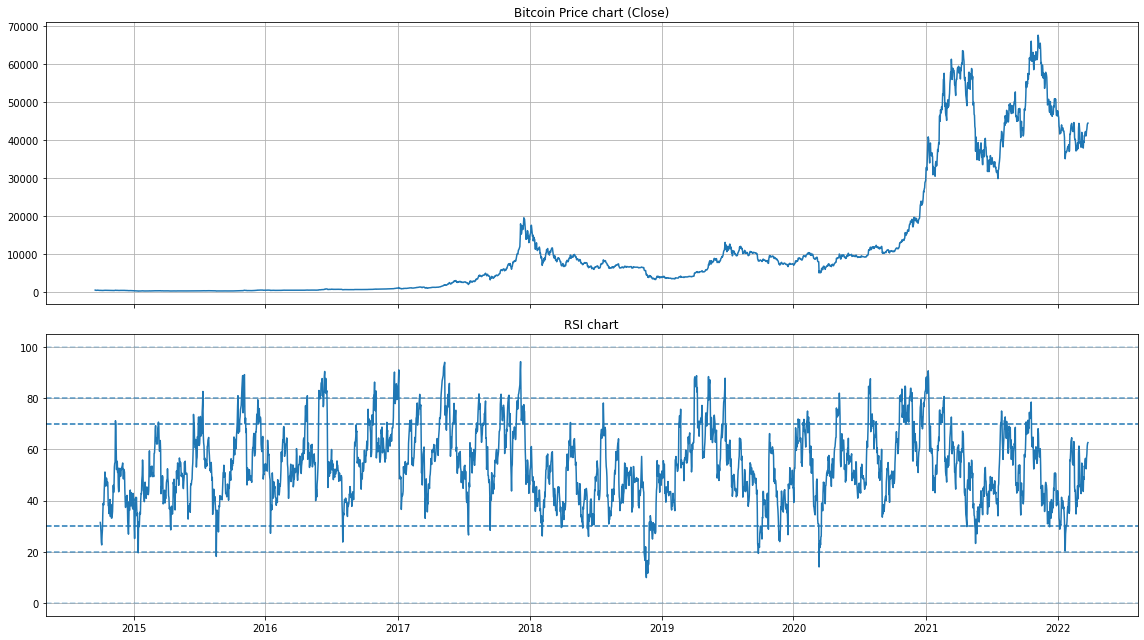

In [19]:
# plot price
fig, axes = plt.subplots(2, 1, sharex=True)
plt.grid(True)
plt.title('Bitcoin Price chart (Close)')
axes[0].plot(data["Close"])
axes[0].grid(True)
axes[0].title.set_text('Bitcoin Price chart (Close)')

# plot correspondingRSI values and significant levels

axes[1].plot(data['rsi_14'])
axes[1].axhline(0, linestyle='--', alpha=0.3)
axes[1].axhline(20, linestyle='--', alpha=0.7)
axes[1].axhline(30, linestyle='--')

axes[1].axhline(70, linestyle='--')
axes[1].axhline(80, linestyle='--', alpha=0.7)
axes[1].axhline(100, linestyle='--', alpha=0.3)

axes[1].grid(True)
axes[1].title.set_text('RSI chart')
plt.tight_layout()

### Momentum
Momentum is the speed or velocity of price changes in a stock, security, or tradable instrument. Momentum shows the rate of change in price movement over a period of time to help investors determine the strength of a trend. Stocks that tend to move with the strength of momentum are called momentum stocks. 

Market momentum is measured by continually taking price differences for a fixed time interval. To construct a 10-day momentum line, simply subtract the closing price 10 days ago from the last closing price. This positive or negative value is then plotted around a zero line. 

$$Momentum=V−V_x $$

Where:
- V=Latest price <br> 
- V<sub>x</sub>=Closing price x days ago  

In [20]:
data["Momentum(10)"]=data["Close"].diff(10)

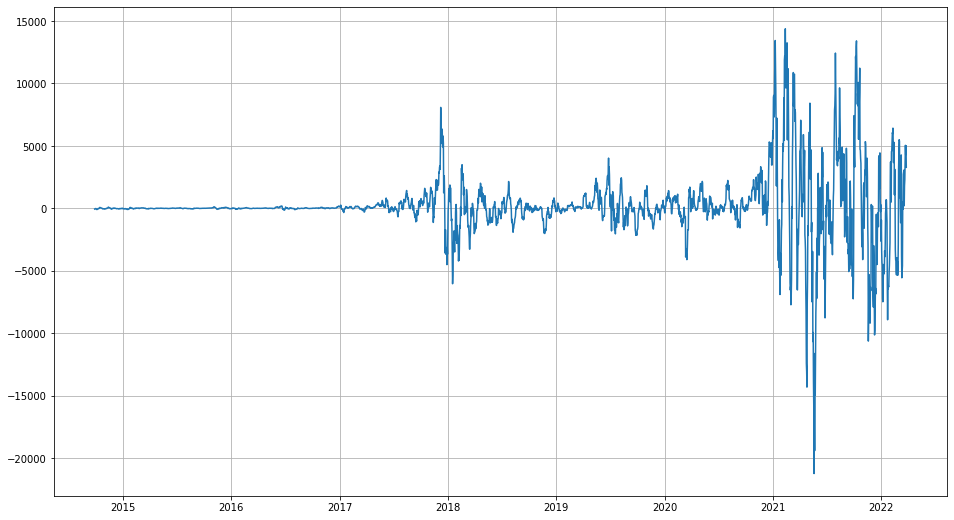

In [21]:
plt.plot(data["Momentum(10)"])
plt.grid(True)
plt.show()

### MACD Level (12, 26)

Moving Average Convergence Divergence (MACD) is a trend following indicator. MACD can be calculated very simply by subtracting the 26 period EMA from the 12 period EMA.<br>
MACD is commonly used by analyzing crossovers, divergences, and periods of steep slope (positive or negative). Along with the MACD line (from subtracting the 12 period EMA from the 16 period EMA) the chart commonly will include a signal line plotted on top of the MACD. This signal line is a 9 day EMA of the MACD. <br>  In a bullish crossover, just like in Moving Averages, a buy signal occurs when MACD crosses above the signal line. A bearish signal occurs when MACD crosses below the signal line. If a crossover occurs with a high sloping MACD, this can be a sign of an overbought or oversold condition, depending on if the crossover is bullish or bearish respectively. MACD is a great indicator for understanding if movement in the price is strong or weak. A weak movement is likely to correct and a strong movement is likely to continue.<br>  Divergences are also simple to understand. When the MACD establishes a high or low diverging from highs or lows in the price it establishes a divergence. A bullish divergence is in place when MACD has two rising lows on the MACD with two falling lows on the asset price. Divergences can be used to find a changing trend. Traders are always looking for the competitive edge and predicting a trend change can be very profitable. Of course, divergences are not completely reliable and should only be used as an additional piece of information, not a sole indication of price direction. <br> Steep slope can signal an overbought or oversold situation. In such a situation a stock’s trend is likely soon to lose steam and see a correction or reversal from current direction.

In [22]:
exp1 = data.Close.ewm(span=12, adjust=False).mean()
exp2 = data.Close.ewm(span=26, adjust=False).mean()

In [23]:
data["MACD"]=exp1-exp2
data["MACD"]

Date
2014-09-17      0.000000
2014-09-18     -2.624024
2014-09-19     -7.014744
2014-09-20     -9.249402
2014-09-21    -11.699137
                 ...    
2022-03-22    367.557259
2022-03-23    496.267336
2022-03-24    676.647807
2022-03-25    841.195815
2022-03-26    966.757060
Name: MACD, Length: 2748, dtype: float64

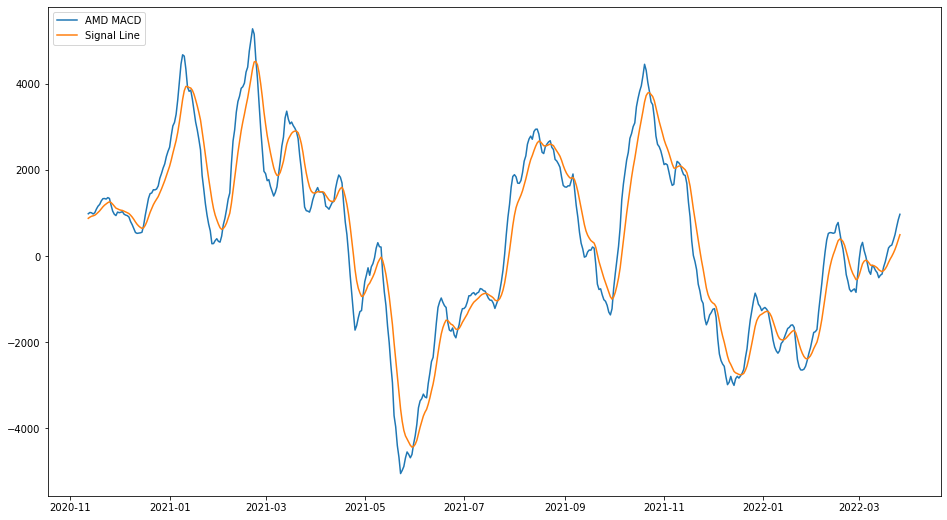

In [24]:
data["exp3"]= data["MACD"].ewm(span=9, adjust=False).mean()
plt.plot(data["MACD"][len(data["MACD"])-500:len(data["MACD"])], label='AMD MACD')
plt.plot(data["exp3"][len(data["MACD"])-500:len(data["MACD"])], label='Signal Line')
plt.legend(loc='upper left')
plt.show()

# Simple moving average

In [25]:
data["MA_(10)"] = data["Close"].rolling(window=10).mean()

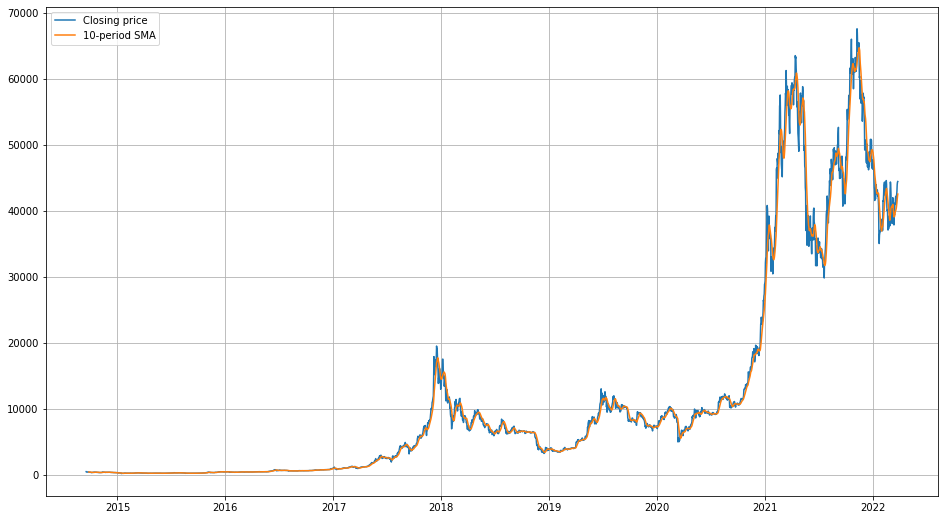

In [26]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['MA_(10)'],label="10-period SMA")
plt.legend()
plt.grid(True)

##### 20-period simple moving average

In [27]:
data["MA_(20)"] = data["Close"].rolling(window=20).mean()

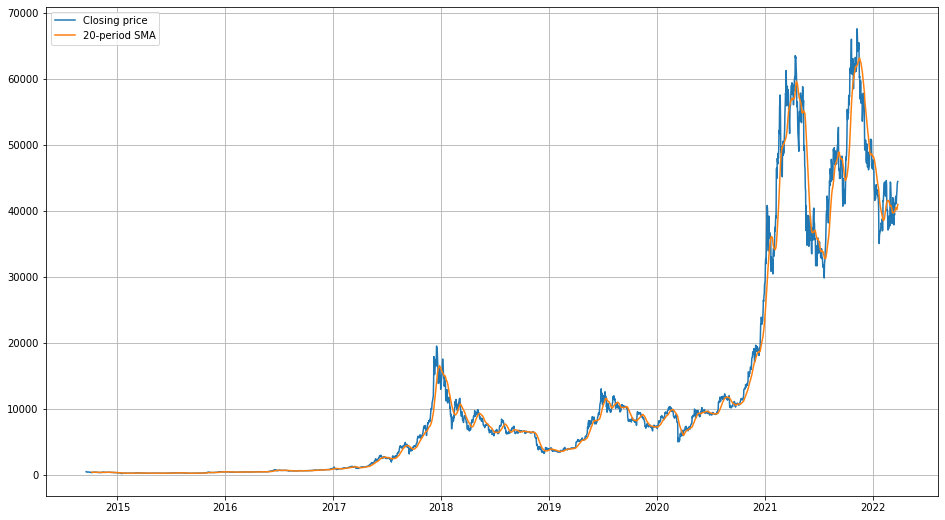

In [28]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['MA_(20)'],label="20-period SMA")
plt.legend()
plt.grid(True)

##### 50-period simple moving average

In [29]:
data["MA_(50)"] = data["Close"].rolling(window=50).mean()

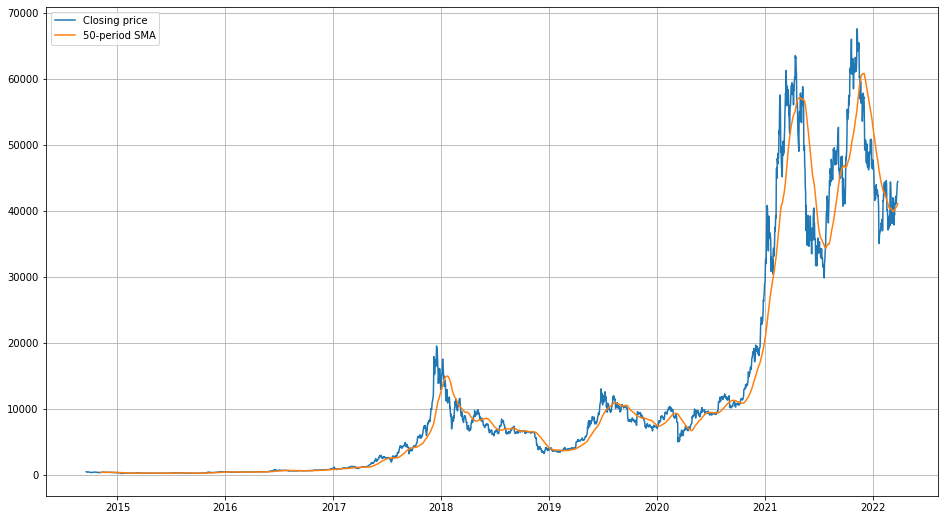

In [30]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['MA_(50)'],label="50-period SMA")
plt.legend()
plt.grid(True)

##### 100-period simple moving average

In [31]:
data["MA_(100)"] = data["Close"].rolling(window=100).mean()

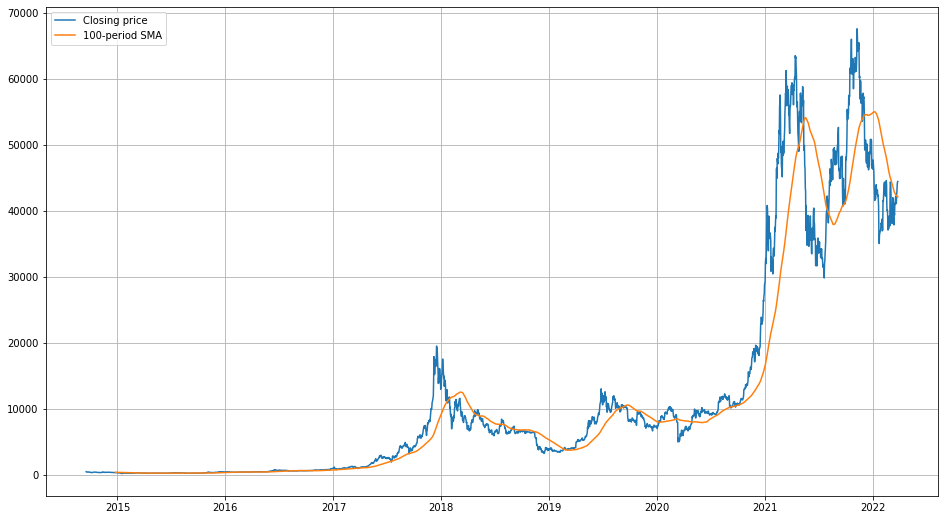

In [32]:
plt.plot(data['Close'],label="Closing price ")
plt.plot(data['MA_(100)'],label="100-period SMA")
plt.legend()
plt.grid(True)

## Average Directional Index (14)

The average directional index (ADX) is a technical analysis indicator used by some traders to determine the strength of a trend.  The trend can be either up or down, and this is shown by two accompanying indicators, the negative directional indicator (-DI) and the positive directional indicator (+DI). Therefore, the ADX commonly includes three separate lines. These are used to help assess whether a trade should be taken long or short, or if a trade should be taken at all. 

 The ADX requires a sequence of calculations due to the multiple lines in the indicator.

\begin{aligned} &\text{+DI} = \left ( \frac{ \text{Smoothed +DM} }{ \text{ATR } } \right ) \times 100 \\ &\text{-DI} = \left ( \frac{ \text{Smoothed -DM} }{ \text{ATR } } \right ) \times 100 \\ &\text{DX} = \left ( \frac{ \mid \text{+DI} - \text{-DI} \mid }{ \mid \text{+DI} + \text{-DI} \mid } \right ) \times 100 \\ &\text{ADX} = \frac{ ( \text{Prior ADX} \times 13 ) + \text{Current ADX} }{ 14 } \\ &\textbf{where:}\\ &\text{+DM (Directional Movement)} = \text{Current High} - \text{PH} \\ &\text{PH} = \text{Previous High} \\ &\text{-DM} = \text{Previous Low} - \text{Current Low} \\ &\text{Smoothed +/-DM} = \textstyle{ \sum_{t=1}^{14} \text{DM} - \left ( \frac{ \sum_{t=1}^{14} \text{DM} }{ 14 } \right ) + \text{CDM} } \\ &\text{CDM} = \text{Current DM} \\ &\text{ATR} = \text{Average True Range} \\ \end{aligned}

The ADX identifies a strong trend when the ADX is over 25 and a weak trend when the ADX is below 20. Crossovers of the -DI and +DI lines can be used to generate trade signals. For example, if the +DI line crosses above the -DI line and the ADX is above 20, or ideally above 25, then that is a potential signal to buy. On the other hand, if the -DI crosses above the +DI, and the ADX is above 20 or 25, then that is an opportunity to enter a potential short trade.  Crosses can also be used to exit current trades. For example, if long, exit when the -DI crosses above the +DI. Meanwhile, when the ADX is below 20 the indicator is signaling that the price is trendless and that it might not be an ideal time to enter a trade. 

In [80]:
df['L-C']

Date
2014-09-17           NaN
2014-09-18     44.230011
2014-09-19     39.907990
2014-09-20      4.912994
2014-09-21     15.722992
                 ...    
2022-03-22    129.714844
2022-03-23    481.300781
2022-03-24    166.792969
2022-03-25    254.648438
2022-03-26    180.054688
Name: L-C, Length: 2748, dtype: float64

In [77]:
df['H-L']

Date
2014-09-17    -2279.825989
2014-09-18    -2291.140015
2014-09-19    -2320.165009
2014-09-20    -2324.704010
2014-09-21    -2335.574005
                  ...     
2022-03-22    40376.707031
2022-03-23    40145.507812
2022-03-24    41383.855469
2022-03-25    42251.492188
2022-03-26    41783.281250
Name: H-L, Length: 2748, dtype: float64

In [81]:
def ADX(data: pd.DataFrame, period: int):
    """
    Computes the ADX indicator.
    """
    
    df = data.copy()
    alpha = 1/period

    # TR
    df['H-L'] = df['High'] - df['Low']
    df['H-C'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-C'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
    del df['H-L'], df['H-C'], df['L-C']

    # ATR
    df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()

    # +-DX
    df['H-pH'] = df['High'] - df['High'].shift(1)
    df['pL-L'] = df['Low'].shift(1) - df['Low']
    df['+DX'] = np.where(
        (df['H-pH'] > df['pL-L']) & (df['H-pH']>0),
        df['H-pH'],
        0.0
    )
    df['-DX'] = np.where(
        (df['H-pH'] < df['pL-L']) & (df['pL-L']>0),
        df['pL-L'],
        0.0
    )
    del df['H-pH'], df['pL-L']

    # +- DMI
    df['S+DM'] = df['+DX'].ewm(alpha=alpha, adjust=False).mean()
    df['S-DM'] = df['-DX'].ewm(alpha=alpha, adjust=False).mean()
    df['+DMI'] = (df['S+DM']/df['ATR'])*100
    df['-DMI'] = (df['S-DM']/df['ATR'])*100
    del df['S+DM'], df['S-DM']

    # ADX
    df['DX'] = (np.abs(df['+DMI'] - df['-DMI'])/(df['+DMI'] + df['-DMI']))*100
    df['ADX'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()
    del df['DX'], df['ATR'], df['TR'], df['-DX'], df['+DX'], df['+DMI'], df['-DMI']

    return df

In [49]:
data=ADX(data,14)

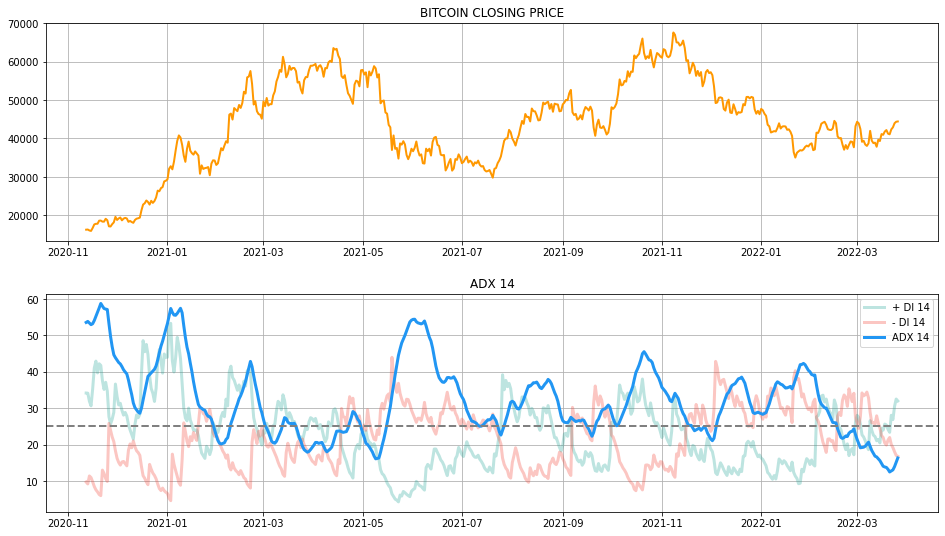

In [40]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(data['Close'][len(data['Close'])-500:len(data['Close'])], linewidth = 2, color = '#ff9800')
ax1.set_title('BITCOIN CLOSING PRICE')
ax1.grid("True")
ax2.plot(data['+DMI'][len(data['Close'])-500:len(data['Close'])], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(data['-DMI'][len(data['Close'])-500:len(data['Close'])] , color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(data['ADX'][len(data['Close'])-500:len(data['Close'])], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.grid("True")
ax2.legend()
ax2.set_title('ADX 14')
plt.show()

### Stochastic K

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0–100 bounded range of values. 

The Formula for the Stochastic Oscillator Is

\begin{aligned} &\text{%K}=\left(\frac{\text{C} - \text{L14}}{\text{H14} - \text{L14}}\right)\times100\\ &\textbf{where:}\\ &\text{C = The most recent closing price}\\ &\text{L14 = The lowest price traded of the 14 previous}\\ &\text{trading sessions}\\ &\text{H14 = The highest price traded during the same}\\ &\text{14-day period}\\ &\text{%K = The current value of the stochastic indicator}\\ \end{aligned}

%K is referred to sometimes as the fast stochastic indicator. The "slow" stochastic indicator is taken as %D = 3-period moving average of %K. <br>
The stochastic oscillator is range-bound, meaning it is always between 0 and 100. This makes it a useful indicator of overbought and oversold conditions. Traditionally, readings over 80 are considered in the overbought range, and readings under 20 are considered oversold.

In [83]:
highest_high=data["High"].rolling(14).max()
lowest_low=data["Low"].rolling(14).min()

data["Stochastic(14)"]=(data["Close"]-lowest_low)/(highest_high-lowest_low)*100

In [84]:
data["Stochastic(3)"] = data["Stochastic(14)"].rolling(window=3).mean()

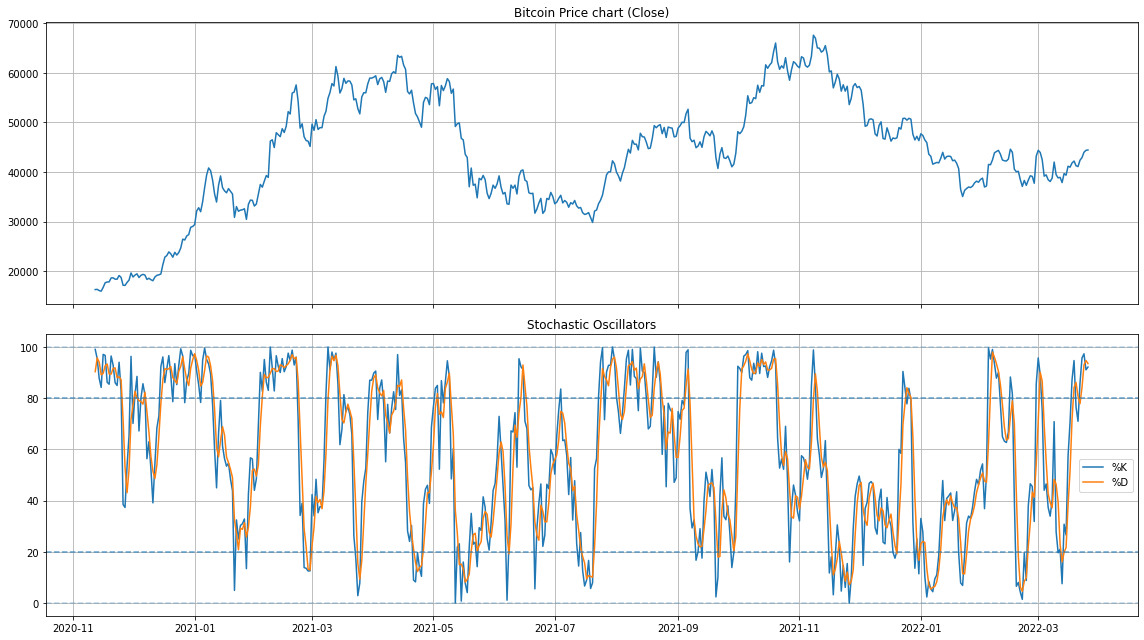

In [85]:
fig, axes = plt.subplots(2, 1, sharex=True)
plt.grid(True)
plt.title('Bitcoin Price chart (Close)')
axes[0].plot(data["Close"][len(data["Close"])-500:len(data["Close"])])
axes[0].grid(True)
axes[0].title.set_text('Bitcoin Price chart (Close)')

axes[1].plot(data["Stochastic(14)"][len(data["Close"])-500:len(data["Close"])],label="%K")
axes[1].plot(data["Stochastic(3)"][len(data["Close"])-500:len(data["Close"])],label="%D")
axes[1].axhline(0, linestyle='--', alpha=0.3)
axes[1].axhline(20, linestyle='--', alpha=0.7)

axes[1].axhline(80, linestyle='--', alpha=0.7)
axes[1].axhline(100, linestyle='--', alpha=0.3)

axes[1].grid(True)
axes[1].title.set_text('Stochastic Oscillators')
axes[1].legend()
plt.tight_layout()

###  Williams Percent Range

Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way.

$$ \frac{Highest High-Close}{Highest High -Lowest Low} $$

Where:
- Highest High=Highest price in the lookbackperiod, typically 14 days <br> 
- Close=Most recent closing price <br>
-Lowest Low=Lowest price in the lookbackperiod, typically 14 days <br>

The indicator is telling a trader where the current price is relative to the highest high over the last 14 periods (or whatever number of lookback periods is chosen).

When the indicator is between -20 and zero the price is overbought, or near the high of its recent price range. When the indicator is between -80 and -100 the price is oversold, or far from the high of its recent range.

During an uptrend, traders can watch for the indicator to move below -80. When the price starts moving up, and the indicator moves back above -80, it could signal that the uptrend in price is starting again.

The same concept could be used to find short trades in a downtrend. When the indicator is above -20, watch for the price to start falling along with the Williams %R moving back below -20 to signal a potential continuation of the downtrend.

Traders can also watch for momentum failures. During a strong uptrend, the price will often reach -20 or above. If the indicator falls, and then can't get back above -20 before falling again, that signals that the upward price momentum is in trouble and a bigger price decline could follow.

The same concept applies to a downtrend. Readings of -80 or lower are often reached. When the indicator can no longer reach those low levels before moving higher it could indicate the price is going to head higher. 



In [86]:
data["Williams Percent Range (14)"]=(highest_high-data["Close"])/(highest_high-lowest_low)*(-100)

In [87]:
data["Williams Percent Range (14)"]

Date
2014-09-17          NaN
2014-09-18          NaN
2014-09-19          NaN
2014-09-20          NaN
2014-09-21          NaN
                ...    
2022-03-22   -14.068741
2022-03-23    -4.257002
2022-03-24    -2.649491
2022-03-25    -8.891696
2022-03-26    -7.831226
Name: Williams Percent Range (14), Length: 2748, dtype: float64

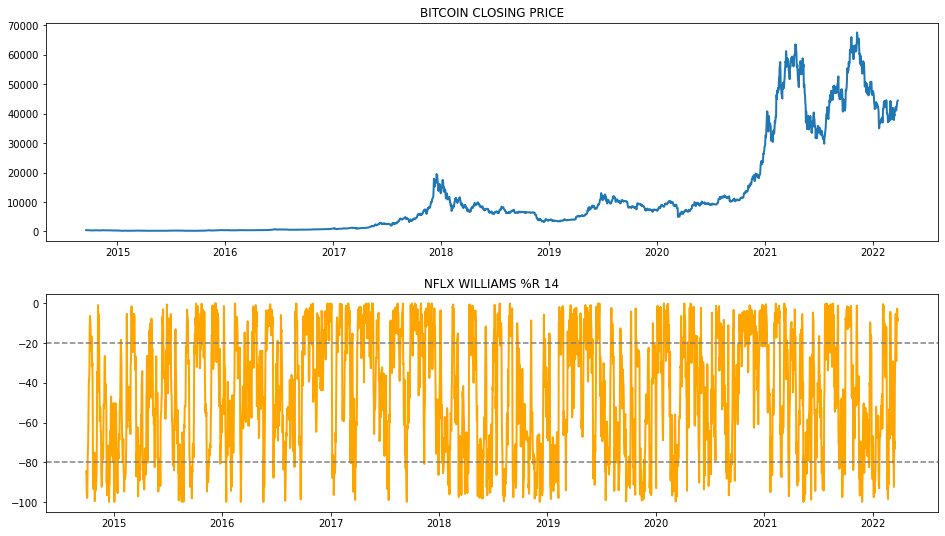

In [88]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(data['Close'], linewidth = 2)
ax1.set_title('BITCOIN CLOSING PRICE')
ax2.plot(data['Williams Percent Range (14)'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('NFLX WILLIAMS %R 14')
plt.show()